### Visión artificial y series de tiempo

1. Reescriba con sus propias manos los dos cuadernos de los enlaces. Entienda cada línea y asegúrese de correr apropiadamente sus códigos localmente y en Colab.

2. Traduzca el [primer cuaderno](https://github.com/AprendizajeProfundo/Diplomado-Avanzado/blob/main/Visi%C3%B3n%20Artificial/Cuadernos/TallerCifar.ipynb) a Tensorflow.
3. Traduzca el [segundo cuaderno](https://github.com/AprendizajeProfundo/Diplomado/blob/master/Temas/M%C3%B3dulo%205-%20Redes%20recurrentes/Cuadernos/rnr_accion_Apple_Prediccion_tres_dias-dropout-.ipynb) a Pytorch.

Entregables. 

Los cuadernos traducidos y corridos.

### 1.) Entendimiento de los cuadernos

###### Cuaderno 1 (Taller Cifar)
¿Qué es cifar?

Es una colección de imágenes que se usan para entrenar algoritmos de aprendizaje automático y visón por computadora. Detalles:

32x32x3, en espacio RGB
50.000 imágenes de entrenamiento
10.000 imágenes de prueba
10 clases:  
    . avión  
    . automovil  
    . ave  
    . gato  
    . venado  
    . perro  
    . rana  
    . caballo  
    . camión  
    . barco  
    
Para definir un clasificador de imagenes haremos los siguientes pasos:

1. Carga y normaliza los conjuntos de datos de entrenamiento y prueba CIFAR10 usando torchvision
2. Definir una red neuronal convolucional
3. Definir una función de pérdida
4. Capacitar a la red en los datos de formación
5. Probar la red en los datos de prueba

In [1]:
import torch # importar pytorch librería de aprendizaje automática
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms #convertir a tensor

from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler

In [2]:
# comprobar si CUDA (Compute Unified Device Architecture) está disponible 
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA no está disponible. Entrenamiento en CPU')
else:
    print('¡CUDA está disponible! Entrenamiento en GPU')

CUDA no está disponible. Entrenamiento en CPU


In [3]:
# número de subprocesos a utilizar para la carga de datos
num_workers = 0
# cuantas muestras por lote cargar
batch_size = 20
# porcentaje del conjunto de entrenamiento para usar como validación
valid_size = 0.2

# convertir datos a un normalizada torch.FloatTensor
transform = transforms.Compose([
    transforms.ToTensor(), # Convierte PIL, Image o np.array a un tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalizar imágenes
    # La normalización ayuda a obtener datos dentro de un rango y reduce la asimetría, la red aprende más rápido y mejor. 
    
]) 

# elegir los conjuntos de datos de entrenamiento y prueba
train_data = datasets.CIFAR10('data', train=True, # Crear conjunto de entrenamiento
                              download=True, transform=transform) # Se aplica transformación de datos normalizados
test_data = datasets.CIFAR10('data', train=False, # Crear conjunto de test
                             download=True, transform=transform)

# obtener índices de entrenamiento que se utilizarán para la validación
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split] # Se encuentra split y asigna antes del split a train y después a valid

# definir muestreadores para obtener lotes de entrenamiento y validación
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# preparar cargadores de datos (combinar conjunto de datos y muestra)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

# especificar las clases de imagen
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


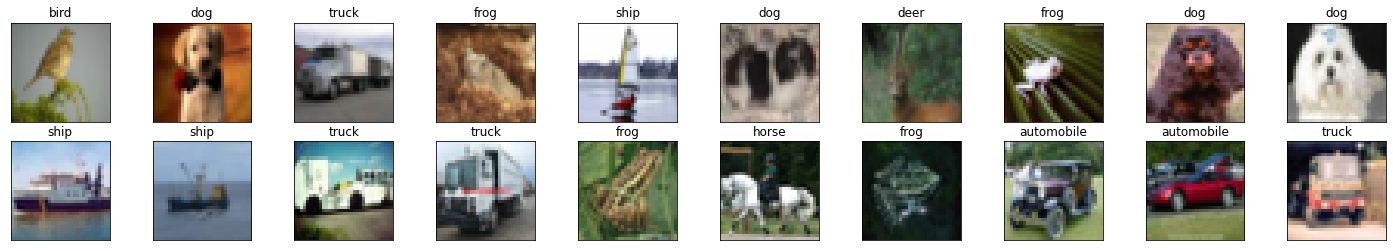

In [4]:
%matplotlib inline

# función auxiliar para desnormalizar y mostrar una imagen
def imshow(img):
    img = img / 2 + 0.5  # desnormalizar
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image (de tensor a imagen)

# obtener un lote de imágenes de entrenamiento
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convertir imágenes a numpy para mostrar
# dibuja las imágenes en el lote, junto con las etiquetas correspondientes
fig = plt.figure(figsize=(25, 4))
# muestra 20 imagenes
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

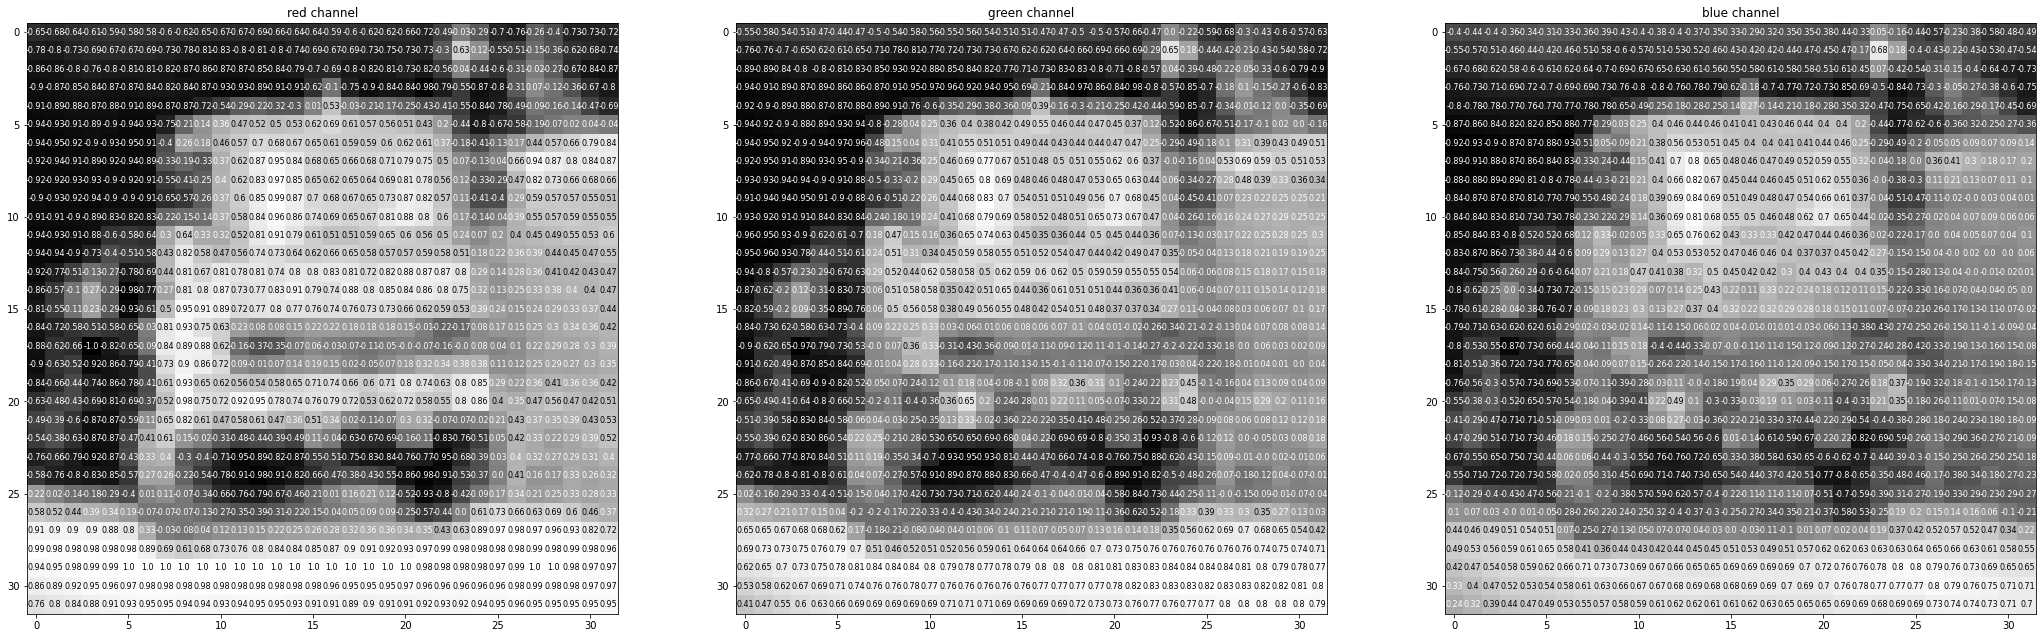

In [5]:
rgb_img = np.squeeze(images[19]) # última imágen del subset mostrado anteriormente removiendo entradas unidimensionales 
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (36, 36)) 
for idx in np.arange(rgb_img.shape[0]): # recorrer cantidad de capas dentro del tensor
    ax = fig.add_subplot(1, 3, idx + 1) # Graficar cada capa del tensor en una subfigura
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray') # escala de grises
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5 
    for x in range(width): # Incluir annotaciones según posición
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')

In [12]:
import torch.nn as nn # componentes básicos de los gráficos:
import torch.nn.functional as F # funciones para gráficos

class Net(nn.Module): # Clase base para una red neuronal
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) # convolución 2D sobre una señal de entrada compuesta por varios planos de entrada.
        self.pool = nn.MaxPool2d(2, 2) # Agrupación máxima 2D
        self.conv2 = nn.Conv2d(6, 16, 5) # convolución 2D
        self.fc1 = nn.Linear(16 * 5 * 5, 120) # Aplica tranformación lineal a la información tamaño de entrada 16*5*5 y salida 120
        self.fc2 = nn.Linear(120, 84) # tamaño de entrada 120 y salida 84
        self.fc3 = nn.Linear(84, 10) # tamaño de entrada 84 y salida 10
    def forward(self, x): # Realización de 
        x = self.pool(F.relu(self.conv1(x))) # Aplica la función de unidad lineal rectificada elemento a elemento
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5) 
        x = F.relu(self.fc1(x)) # Aplica la función de unidad lineal generando mediante transformación lineal anterior 
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
# crear una CNN completa
model = Net()
print(model)
# mover tensores a GPU si CUDA está disponible
if train_on_gpu:
    model.cuda()

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [13]:
import torch.optim as optim

# Especifica funcion de perdidas
criterion = nn.CrossEntropyLoss()
# Especifica optimizador
optimizer = optim.SGD(model.parameters(), lr=.01)

In [14]:
# número de epochs para entrenar el modelo
n_epochs = 30
# Lista para almacenar pérdidas, para visualizar
train_losslist = []
valid_loss_min = np.Inf # realizar un seguimiento del cambio en la pérdida de validación

for epoch in range(1, 30):

    # Realizar un seguimiento del cambio en la pérdida de validación
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # Entrena el modelo #
    ###################
    model.train()
    for data, target in train_loader:
        # mover tensores a GPU si CUDA está disponible
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # borrar los gradientes de todas las variables optimizadas
        optimizer.zero_grad()
        # forward pass: calcule las salidas predichas pasando las entradas al modelo
        output = model(data)
        # calcular la pérdida del lote(batch)
        loss = criterion(output, target)
        # backward pass: calcular el gradiente de la pérdida con respecto a los parámetros del modelo
        loss.backward()
        # realizar un único paso de optimización (actualización de parámetros)
        optimizer.step()
        # actualizar pérdida de entrenamiento
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validar el modelo #
    ######################
    model.eval()
    for data, target in valid_loader:
        # mover tensores a GPU si CUDA está disponible
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: calcular las salidas predichas pasando entradas al modelo
        output = model(data)
        # calcular la pérdida del lote(batch)
        loss = criterion(output, target)
        # actualizar la pérdida de validación promedio 
        valid_loss += loss.item()*data.size(0)
    
    # calcular pérdidas promedio
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
    train_losslist.append(train_loss)
        
    # imprimir estadísticas de entrenamiento/validación
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # guarde el modelo si la pérdida de validación ha disminuido
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 1.766757 	Validation Loss: 0.396788
Validation loss decreased (inf --> 0.396788).  Saving model ...
Epoch: 2 	Training Loss: 1.419038 	Validation Loss: 0.318573
Validation loss decreased (0.396788 --> 0.318573).  Saving model ...
Epoch: 3 	Training Loss: 1.223331 	Validation Loss: 0.308010
Validation loss decreased (0.318573 --> 0.308010).  Saving model ...
Epoch: 4 	Training Loss: 1.133023 	Validation Loss: 0.270811
Validation loss decreased (0.308010 --> 0.270811).  Saving model ...
Epoch: 5 	Training Loss: 1.063209 	Validation Loss: 0.255860
Validation loss decreased (0.270811 --> 0.255860).  Saving model ...
Epoch: 6 	Training Loss: 1.007220 	Validation Loss: 0.248957
Validation loss decreased (0.255860 --> 0.248957).  Saving model ...
Epoch: 7 	Training Loss: 0.959556 	Validation Loss: 0.241142
Validation loss decreased (0.248957 --> 0.241142).  Saving model ...
Epoch: 8 	Training Loss: 0.917014 	Validation Loss: 0.240009
Validation loss decreased (0.24114

In [15]:
print(type(train_losslist)) # Extraer el tipo de dato de la lista utilizada para evaluar la pérdida de la función
print(n_epochs)
n_epochs=[*range(1,30)] # Crear lista con cantidad de entrenamientos realizados

<class 'list'>
30


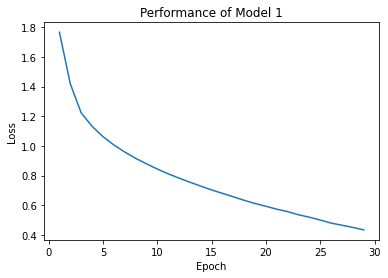

In [20]:
# Gráfica de loss vs epoch
plt.plot(n_epochs, train_losslist)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Performance of Model 1")
plt.show()

In [21]:
# Probar la primera red en el conjunto de datos

# track test loss (Seguimiento de pérdida de prueba)
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterar sobre datos de prueba
for data, target in test_loader:
    # mover tensores a GPU si CUDA está disponible
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: calcular las salidas predichas pasando entradas al modelo
    output = model(data)
    # calcular la pérdida del lote(batch)
    loss = criterion(output, target)
    # actualización de pérdida de prueba 
    test_loss += loss.item()*data.size(0)
    # convertir las probabilidades de salida a la clase predicha
    _, pred = torch.max(output, 1)    
    # comparar predicciones con la etiqueta(label) verdadera
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calcular la precisión de la prueba para cada clase de objeto
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# pérdida de prueba promedio
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10): # Imprime para cada clase la cantidad de aciertos 
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 1.322118

Test Accuracy of airplane: 62% (629/1000)
Test Accuracy of automobile: 80% (806/1000)
Test Accuracy of  bird: 53% (534/1000)
Test Accuracy of   cat: 27% (271/1000)
Test Accuracy of  deer: 63% (637/1000)
Test Accuracy of   dog: 63% (631/1000)
Test Accuracy of  frog: 74% (744/1000)
Test Accuracy of horse: 58% (586/1000)
Test Accuracy of  ship: 76% (764/1000)
Test Accuracy of truck: 65% (652/1000)

Test Accuracy (Overall): 62% (6254/10000)


In [22]:
# Mejora del modelo
class CNN(nn.Module): # Creación de la clase
    def __init__(self):
        
        super(CNN, self).__init__()

        self.conv_layer = nn.Sequential( # Creación de secuencia para cada uno de los bloques 

            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1), # convolución 2D
            nn.BatchNorm2d(32), # Aplica la normalización por lotes sobre una entrada 4D 
            nn.ReLU(inplace=True), # aplicar ReLU y reemplazar
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1), # convolución 2D
            nn.ReLU(inplace=True), 
            nn.MaxPool2d(kernel_size=2, stride=2), # Aplica una agrupación máxima 2D

            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.05), # Poner a cero aleatoriamente canales completos con probabilidad del .05

            # Conv Layer block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # En términos generales cada layer se va ampliando de tamaño

        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(512, 10)
        ) # Posteriormente los layers son contraídos de tamaño


    def forward(self, x):
        """Perform forward."""
        
        # conv layers
        x = self.conv_layer(x)
        
        # flatten
        x = x.view(x.size(0), -1)
        
        # fc layer
        x = self.fc_layer(x)

        return x

# Crear una cnn completa
model = CNN()
print(model)
# mover tensores a GPU si CUDA está disponible
if train_on_gpu:
    model.cuda()

CNN(
  (conv_layer): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Dropout2d(p=0.05, inplace=False)
    (13): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stat

In [23]:
# Especificar funcion de perdidas
criterion = nn.CrossEntropyLoss()
# especificar optimizador
optimizer = optim.SGD(model.parameters(), lr=.001)

In [25]:
# Se repite el entrenamiento
# número de epochs para entrenar el modelo
n_epochs = 30
#Lista para almacenar pérdida para visualizar
train_losslist = []
valid_loss_min = np.Inf # realizar un seguimiento del cambio en la pérdida de validación

for epoch in range(1, 30):

    # hacer un seguimiento de la pérdida de entrenamiento y validación
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # Entrena al modelo #
    ###################
    model.train()
    for data, target in train_loader:
        # mover tensores a GPU si CUDA está disponible
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # limpia(clear) los gradientes de todas las variables optimizadas
        optimizer.zero_grad()
        # forward pass: calcular las salidas predichas pasando entradas al modelo
        output = model(data)
        # calcular la pérdida del lote(batch)
        loss = criterion(output, target)
        # backward pass: calcular el gradiente de la pérdida con respecto a los parámetros del modelo
        loss.backward()
        # realizar un único paso de optimización (actualización de parámetros)
        optimizer.step()
        # actualizar pérdida de entrenamiento
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # Valida el modelo #
    ######################
    model.eval()
    for data, target in valid_loader:
        # mover tensores a GPU si CUDA está disponible
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: calcular las salidas predichas pasando entradas al modelo
        output = model(data)
        # calcular la pérdida del lote(batch)
        loss = criterion(output, target)
        # actualizar la pérdida de validación promedio 
        valid_loss += loss.item()*data.size(0)
    
    # calcular pérdidas promedio
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
    train_losslist.append(train_loss)
        
    # imprimir estadísticas de entrenamiento/validación
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # guarde el modelo si la pérdida de validación ha disminuido
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 1.607879 	Validation Loss: 0.342841
Validation loss decreased (inf --> 0.342841).  Saving model ...
Epoch: 2 	Training Loss: 1.316575 	Validation Loss: 0.297499
Validation loss decreased (0.342841 --> 0.297499).  Saving model ...
Epoch: 3 	Training Loss: 1.167179 	Validation Loss: 0.270499
Validation loss decreased (0.297499 --> 0.270499).  Saving model ...
Epoch: 4 	Training Loss: 1.062229 	Validation Loss: 0.244524
Validation loss decreased (0.270499 --> 0.244524).  Saving model ...
Epoch: 5 	Training Loss: 0.968077 	Validation Loss: 0.217575
Validation loss decreased (0.244524 --> 0.217575).  Saving model ...
Epoch: 6 	Training Loss: 0.882190 	Validation Loss: 0.199415
Validation loss decreased (0.217575 --> 0.199415).  Saving model ...
Epoch: 7 	Training Loss: 0.803751 	Validation Loss: 0.187937
Validation loss decreased (0.199415 --> 0.187937).  Saving model ...
Epoch: 8 	Training Loss: 0.738547 	Validation Loss: 0.178613
Validation loss decreased (0.18793

In [26]:
print(type(train_losslist)) # Extraer nuevamente los valores de pérdida durante las ejecuciones del entrenamiento 
print(n_epochs)
n_epochs=[*range(1,30)]

<class 'list'>
30


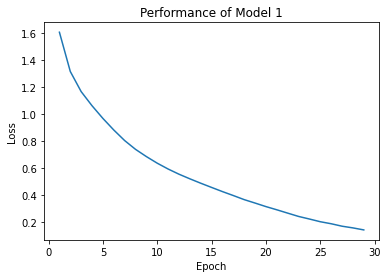

In [27]:
# Graficación del segundo modelo entre loss vs epoch 
plt.plot(n_epochs, train_losslist)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Performance of Model 1")
plt.show()

In [28]:
# Validación de ajuste del segundo modelo -> Se evidencia una mejora en el resultado
# track test loss (Seguimiento de pérdida de prueba)
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterar sobre datos de prueba
for data, target in test_loader:
    # mover tensores a GPU si CUDA está disponible
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: calcular las salidas predichas pasando entradas al modelo
    output = model(data)
    # calcular la pérdida del lote(batch)
    loss = criterion(output, target)
    # actualización de pérdida de prueba 
    test_loss += loss.item()*data.size(0)
    # convertir las probabilidades de salida a la clase predicha
    _, pred = torch.max(output, 1)    
    # comparar predicciones con la etiqueta(label) verdadera
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calcular la precisión de la prueba para cada clase de objeto
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# pérdida de prueba promedio
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.850337

Test Accuracy of airplane: 77% (777/1000)
Test Accuracy of automobile: 92% (920/1000)
Test Accuracy of  bird: 70% (707/1000)
Test Accuracy of   cat: 65% (654/1000)
Test Accuracy of  deer: 71% (714/1000)
Test Accuracy of   dog: 69% (690/1000)
Test Accuracy of  frog: 83% (830/1000)
Test Accuracy of horse: 71% (714/1000)
Test Accuracy of  ship: 91% (914/1000)
Test Accuracy of truck: 72% (725/1000)

Test Accuracy (Overall): 76% (7645/10000)


##### Cuaderno 2 (Predicción AAPL)

In [32]:
import tensorflow as tf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline
from sklearn.preprocessing import MinMaxScaler

#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

#importing required libraries
from sklearn.preprocessing import MinMaxScaler

# importa objetos de keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM
print("Versión de Tensorflow: ", tf.__version__)

# optimizador
from tensorflow.keras.optimizers import Adam

Versión de Tensorflow:  2.10.0


In [33]:
# Lectura del archivo local
df = pd.read_csv(r'C:\Users\juaaceve\OneDrive - Grupo Bancolombia\Personal\Maestría\Procesamiento de Lenguaje Natural y Aprendizaje Profundo\Assignments\data\AAPL_2006-01-01_to_2018-01-01.csv')

In [34]:
# looking at the first five rows of the data
print('\n Shape of the data:')
print(df.shape)
df.head() # Visualización de las primeras 5 observaciones


 Shape of the data:
(3019, 7)


,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,10.34,10.68,10.32,10.68,201853036,AAPL
1,2006-01-04,10.73,10.85,10.64,10.71,155225609,AAPL
2,2006-01-05,10.69,10.70,10.54,10.63,112396081,AAPL
3,2006-01-06,10.75,10.96,10.65,10.90,176139334,AAPL
4,2006-01-09,10.96,11.03,10.82,10.86,168861224,AAPL


In [35]:
df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d') # Convertir date a formato fecha
df.index = df['Date']
# df = df.sort_index(ascending=True, axis=0)
data = pd.DataFrame(df[['Date', 'Close']]) #Crear df con datos de fecha y cerrado

#setting index
data.index = data.Date # Manejar fechas como indices
data.drop('Date', axis=1, inplace=True)
data.head() # Visualización 5 observaciones

,Close
Date,
2006-01-03,10.68
2006-01-04,10.71
2006-01-05,10.63
2006-01-06,10.90
2006-01-09,10.86


In [36]:
len_data = len(data) # Cantidad de datos en la base de datos
len_train = int(len_data*0.8) # 80%  = 3019 Extraer 80 % para entrenamiento
len_test = len_data- len_train # 20% = 2415 Extraer 20 % para entrenamiento
print (len_data, '=', len_train, '+',len_test) 

3019 = 2415 + 604


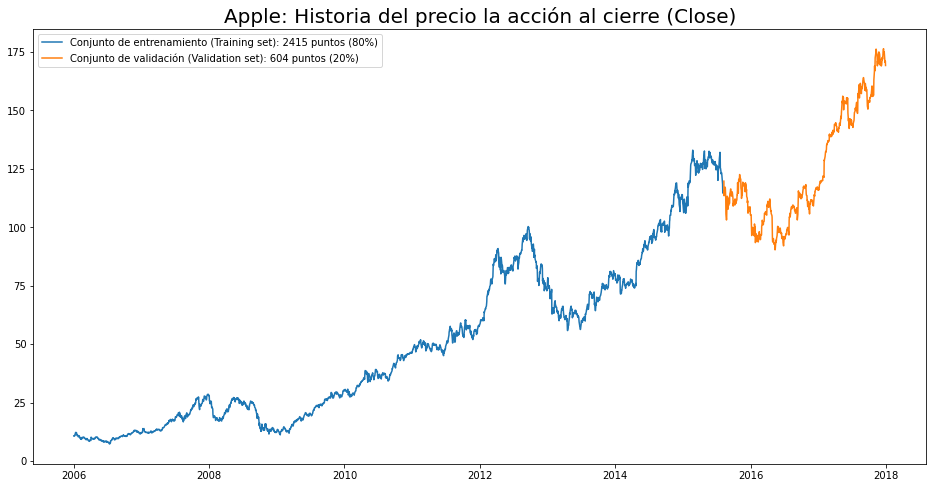

In [37]:
# Graficar conjunto de entrenamiento y validación de datos 
plt.figure(figsize=(16,8))
plt.plot(data[:len_train], label='Conjunto de entrenamiento (Training set): {} puntos (80%)'.format(len_train))
plt.plot(data['Close'][len_train:], label='Conjunto de validación (Validation set): {} puntos (20%)'.format(len_test)) #248 data
plt.title("Apple: Historia del precio la acción al cierre (Close)", size = 20)
plt.legend()
plt.show()

In [38]:
# ------ Entrenamiento de la red LSTM ------ 
# creating train and test sets
dataset = data.values


# create the scaler object and scale the data -> Rango[0,1]
scaler = MinMaxScaler(feature_range=(0, 1))
#scaled_data = np.array(scaler.fit_transform(dataset))
dataset = np.squeeze(np.array(scaler.fit_transform(dataset)),axis=1)
# dataset = pd.DataFrame(scaled_data,index=data.index, columns=['serie'])

dataset.shape # Tamaño 

(3019,)

In [39]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    ''' dataset: conjunto de datos
        start_index: índice inicial de donde empezar a tomar los datos
        end_index: índice final para tomar los datos. None para tomarlos todos
        history_size: tamaño de la venytana para crear las secuencias
        target_size: dentro de cuántas observaciones futuras desea pronosticar
    '''  
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None: # Identificar si son secuencias de entrenamiento o de validación (usar None)
        end_index = len(dataset) - target_size 

    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])

    return np.array(data), np.array(labels)

In [40]:
tf.random.set_seed(100) # Se coloca una semilla para gerantizar reproductibidad

past_history = 60 # tamaño secuencias de entrada
future_target = 3 # días adelante
TRAIN_SPLIT = int(len_data*0.8) #2415: nuḿer0 de datos para el entrenamiento

# secuencias de entrenamiento
X_train, y_train = univariate_data(dataset, 0, TRAIN_SPLIT, # aplicación de distribución univariada
                                           past_history,
                                           future_target)

#secuencias de validación
# No se usará ningún dato que el modelo haya visto
X_test, y_test = univariate_data(dataset, TRAIN_SPLIT, None,
                                       past_history,
                                       future_target)

print(TRAIN_SPLIT)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

2415
(2355, 60, 1)
(2355,)
(541, 60, 1)
(541,)


In [41]:
# Entrenar modelo a 1d 
# shapes

input_shape = (X_train.shape[1], X_train.shape[2]) # Tamaño 
units = 64 

# layers
inputs = Input(input_shape)
#x = Dropout(0.0, name= 'Dropout_01')(inputs)
#x = LSTM(units=units, name='LSTM_layer')(x)
x = LSTM(units=units, return_sequences=True,name='LSTM_layer')(inputs)
x = Dropout(0.4, name= 'Dropout_02')(x)
x = LSTM(units=units//2, name='LSTM_layer_2')(x)
x = Dropout(0.4, name= 'Dropout_03')(x)
outputs = Dense(1)(x)

# model
model_01 = Model(inputs=inputs, outputs=outputs, name='series_LSTM_model')
model_01.summary()

Model: "series_LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 60, 1)]           0         
                                                                 
 LSTM_layer (LSTM)           (None, 60, 64)            16896     
                                                                 
 Dropout_02 (Dropout)        (None, 60, 64)            0         
                                                                 
 LSTM_layer_2 (LSTM)         (None, 32)                12416     
                                                                 
 Dropout_03 (Dropout)        (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 29,345
Trainable params: 29,345
Non

In [42]:
model_01.compile(loss='mean_squared_error', # Función de pérdida MSE
  optimizer=Adam(0.001)) # Optimizador Adam 

In [43]:
# Entrenamiento del modelo 
#history = model_01.fit(X_train,y_train,epochs=20,batch_size=32)
tf.random.set_seed(100) # permitir réplica
history = model_01.fit(
    X_train, y_train,
    epochs=15,
    batch_size=32,
    validation_split=0.1,
    verbose=1,
    shuffle=False
) # Ajuste del modelo 

Epoch 1/15
67/67 [==============================] - 4s 33ms/step - loss: 0.0027 - val_loss: 0.0030
Epoch 2/15
67/67 [==============================] - 2s 33ms/step - loss: 0.0039 - val_loss: 0.0045
Epoch 3/15
67/67 [==============================] - 3s 47ms/step - loss: 0.0031 - val_loss: 9.2392e-04
Epoch 4/15
67/67 [==============================] - 3s 43ms/step - loss: 0.0037 - val_loss: 6.8209e-04
Epoch 5/15
67/67 [==============================] - 3s 42ms/step - loss: 0.0019 - val_loss: 0.0014
Epoch 6/15
67/67 [==============================] - 3s 40ms/step - loss: 0.0019 - val_loss: 7.2283e-04
Epoch 7/15
67/67 [==============================] - 3s 40ms/step - loss: 0.0023 - val_loss: 0.0020
Epoch 8/15
67/67 [==============================] - 3s 44ms/step - loss: 0.0015 - val_loss: 8.5998e-04
Epoch 9/15
67/67 [==============================] - 3s 42ms/step - loss: 0.0026 - val_loss: 8.4247e-04
Epoch 10/15
67/67 [==============================] - 3s 40ms/step - loss: 0.0025 - val_lo

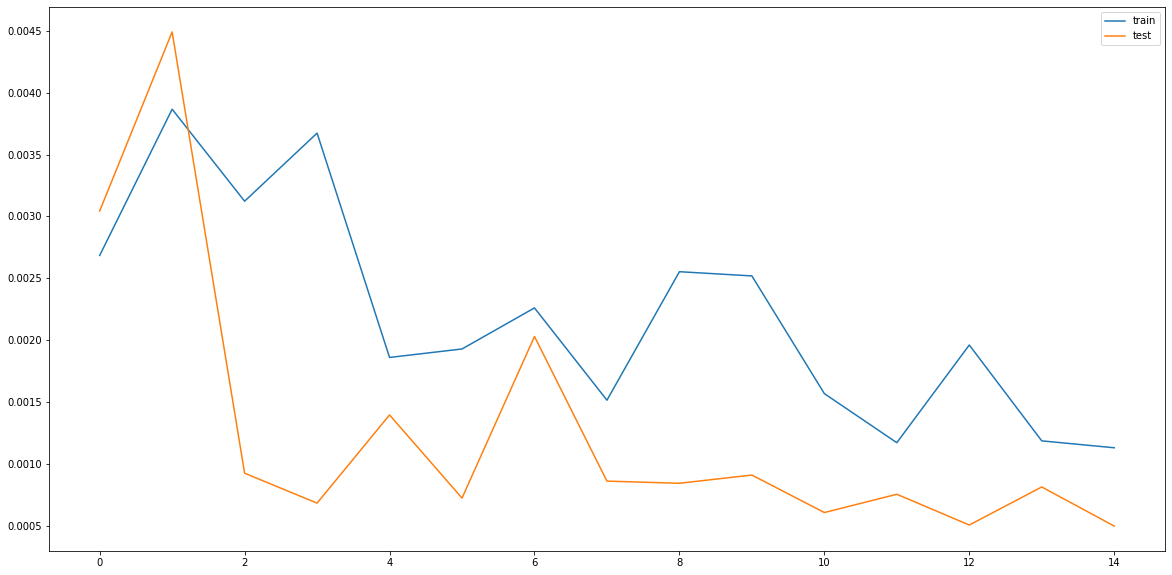

In [44]:
# Graficación de loss & val_loss
plt.plot(history.history['loss'], label='train') # datos de entrenamiento
plt.plot(history.history['val_loss'], label='test') # datos de testeo
plt.legend();

In [45]:
X_test.shape

# predictions
prediction = model_01.predict(X_test)

print(prediction.shape) # Tamaño de la predicción
print(y_test.shape) 

17/17 [==============================] - 1s 11ms/step
(541, 1)
(541,)


In [46]:
y_train_p = y_train
y_test_p = y_test 
y_pred_p = np.squeeze(prediction, axis=-1) # Eliminar dimensiones sobrantes con fines de graficar

In [47]:
print(y_train_p.shape)
print(y_test_p.shape)
print(y_pred_p.shape)

k=0
for i,j in zip(y_test_p, y_pred_p):
    print (i,j, i-j)
    k+=1
    if k==10:
        break

(2355,)
(541,)
(541,)
0.6727745596406196 0.65761036 0.015164202832910867
0.6698782361981322 0.66277844 0.007099799060528489
0.6474169523584349 0.6672523 -0.019835349811364922
0.6435157820073296 0.6702302 -0.026714427820093478
0.6412105449816764 0.6721316 -0.030921053014081656
0.6212318240926825 0.6729184 -0.0516865552141107
0.6321078141624307 0.67077166 -0.038663844258132074
0.6292114907199433 0.6668511 -0.03763961258587334
0.6504906017259725 0.66209626 -0.011605660252176908
0.6592977893368012 0.6553833 0.0039145004764801206


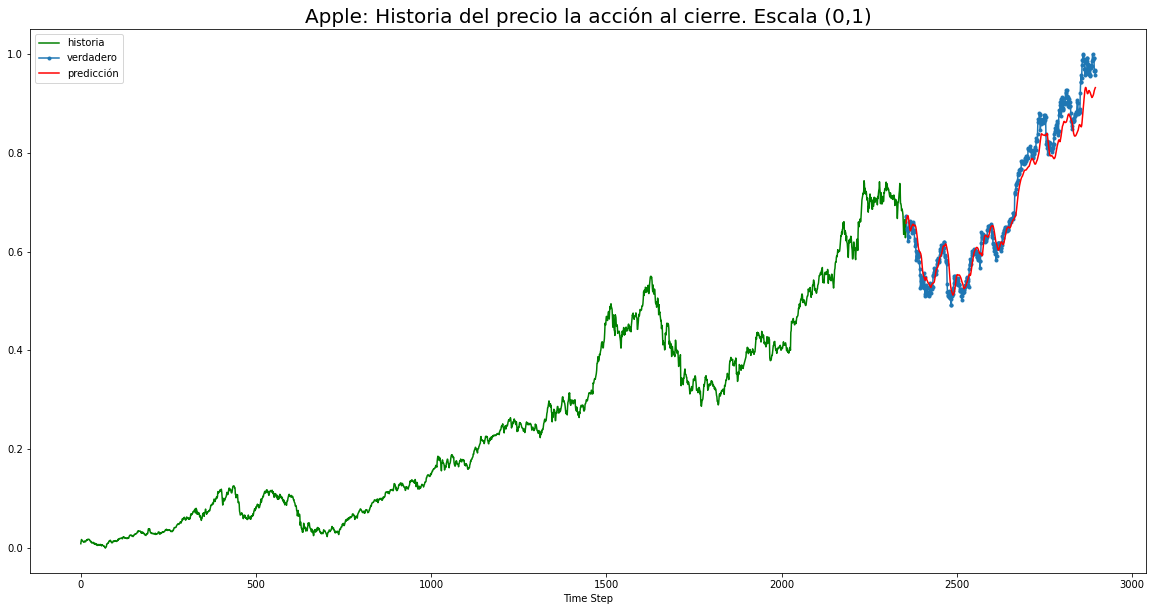

In [48]:
#### Gráfica de predicciones
plt.plot(np.arange(0, len(y_train_p)), y_train_p, 'g', label="historia")
plt.plot(np.arange(len(y_train_p), len(y_train_p) + len(y_test_p)), y_test_p, marker='.', label="verdadero")
plt.plot(np.arange(len(y_train_p), len(y_train_p) + len(y_test_p)), y_pred_p, 'r', label="predicción")

plt.xlabel('Time Step')
plt.title("Apple: Historia del precio la acción al cierre. Escala (0,1)", size = 20)
plt.legend()
plt.show();

In [49]:
# Revirtiendo escala de 0-1 a escala original
y_pred_or = scaler.inverse_transform(y_pred_p.reshape(-1,1))
y_test_or = scaler.inverse_transform(y_test_p.reshape(-1,1))

In [50]:
k=0
for i,j in zip(y_test_or, y_pred_or): 
    print (i,j, i-j) # Valor de test, valor predicho y diferencia
    k+=1
    if k==10:
        break

[121.06] [118.494514] [2.56548553]
[120.57] [119.36885] [1.20114929]
[116.77] [120.12574] [-3.35574005]
[116.11] [120.62955] [-4.51954712]
[115.72] [120.951225] [-5.23122528]
[112.34] [121.08433] [-8.7443277]
[114.18] [120.721146] [-6.54114563]
[113.69] [120.05787] [-6.36786896]
[117.29] [119.25344] [-1.96344086]
[118.78] [118.117744] [0.66225555]


In [51]:
rmsLSTM = np.sqrt(np.mean(np.power(y_pred_or-y_test_or,2))) 
# Raiz del promedio de la diferencia entre test y pred elevado al cuadrado
print(rmsLSTM) # Valor de ajuste  

5.8220124236506114


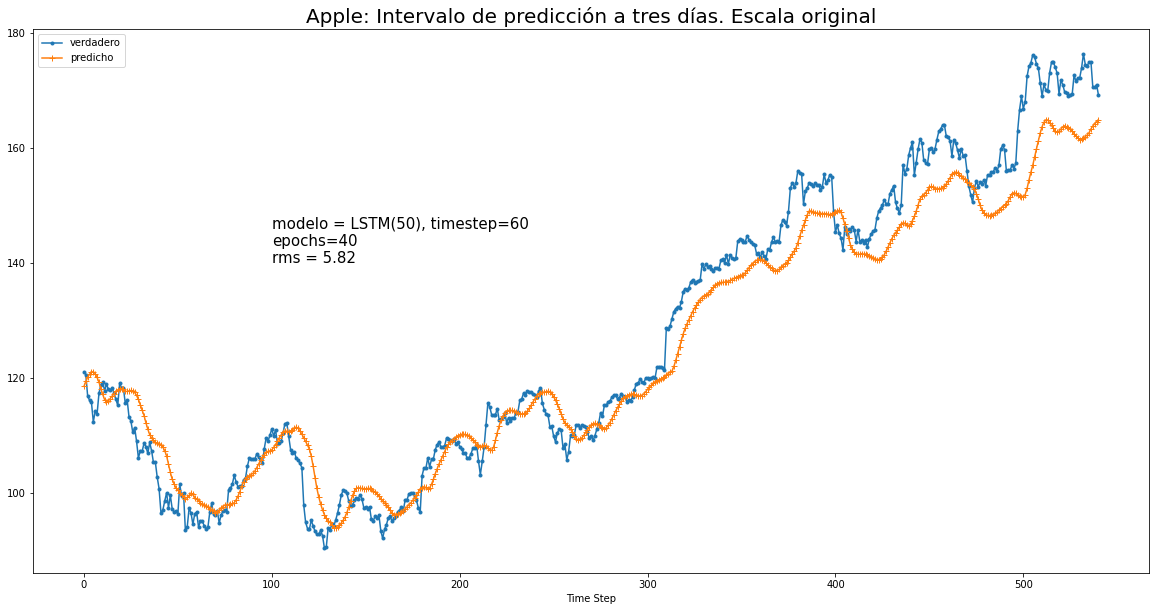

In [52]:
# Graficación de los datos predichos vs verdaderos con escala original
plt.plot(np.arange(0, len(y_test_or)), y_test_or, marker='.', label="verdadero")
plt.plot(np.arange(0, len(y_test_or)), y_pred_or, marker='+', label="predicho")
plt.xlabel('Time Step')
plt.annotate("rms = "+str(round(rmsLSTM,2)) , xy=(100, 140), size = 15) #Agregar notacion en cordenadas xy
plt.annotate("modelo = LSTM(50), timestep=60" , xy=(100, 146), size = 15)
plt.annotate("epochs=40" , xy=(100, 143), size = 15)
plt.title("Apple: Intervalo de predicción a tres días. Escala original", size = 20)
plt.legend()
plt.show();

### 2.) Traduzca el primer cuaderno a Tensorflow.

In [53]:
import numpy
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.constraints import maxnorm
from keras.utils import np_utils
from keras.datasets import cifar10 # Cargar misma base de datos de pytorch

In [54]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data() # Carga de datos

# Normalización de datos entre el rango 0-1
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = X_train / 255.0
X_test = X_test / 255.0

170498071/170498071 [==============================] - 14s 0us/step


In [55]:
# Realizar clasificación binaria 
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
class_num = y_test.shape[1]

In [56]:
### Diseño del modelo 
model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=X_train.shape[1:], padding='same')) # No cambiar tamaño de imágen
model.add(Activation('relu')) # Empleamos relu como función de activación 

In [57]:
# Eliminar conexiones existentes con el fin de evitar el sobreajuste
model.add(Dropout(0.2)) # Eliminar 20% (deserción)
model.add(BatchNormalization()) # Normalización de las entradas a las capas 

In [58]:
# Adicionamos otra capa convolucional con mayor tamaño para aprender representaciones más complejas
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))

# Aplicar deserción y normalidad en la nueva capa
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(BatchNormalization())

# repetimos proceso 
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(BatchNormalization())
    
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Flatten()) # Convertir en una sola matriz
model.add(Dropout(0.2))

In [59]:
model.add(Dense(256, kernel_constraint=maxnorm(3))) # Denseimportación y creamos la primera capa densamente conectada.
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
    
model.add(Dense(128, kernel_constraint=maxnorm(3)))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

In [60]:
model.add(Dense(class_num))
model.add(Activation('softmax')) # selecciona la neurona con mayor probabilidad como salida

In [61]:
epochs = 3 # Se realizan pocos pasos para cuestiones de representar el modelo en poco tiempo
optimizer="adam" # Usamos algoritmo adam

model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 activation_1 (Activation)   (None, 32, 32, 64)        0         
                                                        

In [63]:
# Ajuste del modelo
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=64)

Epoch 1/3
782/782 [==============================] - 189s 241ms/step - loss: 1.5120 - accuracy: 0.4619 - val_loss: 1.1707 - val_accuracy: 0.5741
Epoch 2/3
782/782 [==============================] - 185s 237ms/step - loss: 1.0282 - accuracy: 0.6344 - val_loss: 0.8868 - val_accuracy: 0.6923
Epoch 3/3
782/782 [==============================] - 184s 236ms/step - loss: 0.8436 - accuracy: 0.7067 - val_loss: 0.7763 - val_accuracy: 0.7234


In [64]:
# Evaluación del modelo 
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 72.34%


### 3.) Traduzca el segundo cuaderno a Pytorch.

In [65]:
import pandas as pd

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

In [68]:
df = pd.read_csv(r"C:\Users\juaaceve\OneDrive - Grupo Bancolombia\Personal\Maestría\Procesamiento de Lenguaje Natural y Aprendizaje Profundo\Assignments\data\AAPL_2006-01-01_to_2018-01-01.csv") # Cargar base de datos
df.head()

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,10.34,10.68,10.32,10.68,201853036,AAPL
1,2006-01-04,10.73,10.85,10.64,10.71,155225609,AAPL
2,2006-01-05,10.69,10.70,10.54,10.63,112396081,AAPL
3,2006-01-06,10.75,10.96,10.65,10.90,176139334,AAPL
4,2006-01-09,10.96,11.03,10.82,10.86,168861224,AAPL


In [69]:
# looking at the first five rows of the data
print('\n Shape of the data:')
print(df.shape)
df.head() # Visualización de las primeras 5 observaciones


 Shape of the data:
(3019, 7)


,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,10.34,10.68,10.32,10.68,201853036,AAPL
1,2006-01-04,10.73,10.85,10.64,10.71,155225609,AAPL
2,2006-01-05,10.69,10.70,10.54,10.63,112396081,AAPL
3,2006-01-06,10.75,10.96,10.65,10.90,176139334,AAPL
4,2006-01-09,10.96,11.03,10.82,10.86,168861224,AAPL


In [72]:
df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d') # Convertir date a formato fecha
df.index = df['Date']
# df = df.sort_index(ascending=True, axis=0)
df = pd.DataFrame(df[['Date', 'Close']]) #Crear df con datos de fecha y cerrado

#setting index
df.index = df.Date # Manejar fechas como indices
df.drop('Date', axis=1, inplace=True)
df.head() # Visualización 5 observaciones

,Close
Date,
2006-01-03,10.68
2006-01-04,10.71
2006-01-05,10.63
2006-01-06,10.90
2006-01-09,10.86


In [74]:
# Graficación de los datos
pio.templates.default = "plotly_white"

plot_template = dict(
    layout=go.Layout({
        "font_size": 18,
        "xaxis_title_font_size": 24,
        "yaxis_title_font_size": 24})
)

fig = px.line(df, labels=dict(
    created_at="Date", value="Close price", variable="Sensor"
))
fig.update_layout(
  template=plot_template, legend=dict(orientation='h', y=1.02, title_text="")
)
fig.show()

In [100]:
features = list(df.columns.difference([target_sensor]))

forecast_lead = 15 # Forecast para 15 días 
target = "Close"

df[target] = df[target_sensor].shift(-forecast_lead)
df = df.iloc[:-forecast_lead]

<ipython-input-100-108d3f6cef51>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [102]:
test_start = "2015-10-10" # Segmentación de la base de datos 

df_train = df.loc[:test_start].copy()
df_test = df.loc[test_start:].copy()

print("Test set fraction:", len(df_test) / len(df))

Test set fraction: 0.17731682837069254


In [103]:
# Estandarización de los datos
target_mean = df_train[target].mean()
target_stdev = df_train[target].std()

for c in df_train.columns:
    mean = df_train[c].mean()
    stdev = df_train[c].std()

    df_train[c] = (df_train[c] - mean) / stdev
    df_test[c] = (df_test[c] - mean) / stdev

In [104]:
import torch
from torch.utils.data import Dataset

# Para el entrenamiento del modelo empleamos secuencias de las observaciones

class SequenceDataset(Dataset): # Modificación del dataset para que Torch pueda trabajarlo
    def __init__(self, dataframe, target, features, sequence_length=5):
        self.features = features
        self.target = target
        self.sequence_length = sequence_length
        self.y = torch.tensor(dataframe[self.target].values).float()
        self.X = torch.tensor(dataframe[self.features].values).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i): # Método que permite la transformación de los datos
        if i >= self.sequence_length - 1:
            i_start = i - self.sequence_length + 1
            x = self.X[i_start:(i + 1), :]
        else:
            padding = self.X[0].repeat(self.sequence_length - i - 1, 1)
            x = self.X[0:(i + 1), :]
            x = torch.cat((padding, x), 0)

        return x, self.y[i]

In [105]:
i = 27
sequence_length = 4

# Dataset de entrenamiento
train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)

X, y = train_dataset[i]
print(X)

tensor([[-1.1707],
        [-1.1687],
        [-1.1763],
        [-1.1854]])


In [106]:
# Si tomamos el índice 28 en su lugar, vemos que las filas se desplazan hacia adelante en el tiempo 1 paso

X, y = train_dataset[i + 1]
print(X)

print(df_train[features].iloc[(i - sequence_length + 1): (i + 1)])

tensor([[-1.1687],
        [-1.1763],
        [-1.1854],
        [-1.1820]])
            Close_lead15
Date                    
2006-02-07     -1.170684
2006-02-08     -1.168705
2006-02-09     -1.176339
2006-02-10     -1.185387


In [107]:
from torch.utils.data import DataLoader
torch.manual_seed(99)

# Dibujará minibatches de datos para nosotros
train_loader = DataLoader(train_dataset, batch_size=3, shuffle=True) 

X, y = next(iter(train_loader))
print(X.shape)
print(X)

torch.Size([3, 4, 1])
tensor([[[ 0.4091],
         [ 0.4082],
         [ 0.3633],
         [ 0.3520]],

        [[ 1.0015],
         [ 1.0054],
         [ 1.0374],
         [ 1.0651]],

        [[-0.9812],
         [-0.9713],
         [-0.9852],
         [-0.9798]]])


In [108]:
torch.manual_seed(101)

batch_size = 4
sequence_length = 30

# Entrenamiento del modelo

train_dataset = SequenceDataset( # Datos de entrenamiento real
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)
test_dataset = SequenceDataset( # Datos de test
    df_test,
    target=target,
    features=features,
    sequence_length=sequence_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # Convertir datos al dataloader
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) # Convertir datos al dataloader

X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([4, 30, 1])
Target shape: torch.Size([4])


In [109]:
from torch import nn

class ShallowRegressionLSTM(nn.Module): # Modelo de entrenamiento basado en regresión LSTM 
    def __init__(self, num_sensors, hidden_units):
        super().__init__()
        self.num_sensors = num_sensors  # número de features
        self.hidden_units = hidden_units
        self.num_layers = 1

        self.lstm = nn.LSTM(
            input_size=num_sensors,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers=self.num_layers
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        
        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn[0]).flatten()  # First dim of Hn is num_layers, which is set to 1 above.

        return out

In [110]:
learning_rate = 0.01
num_hidden_units = 16

model = ShallowRegressionLSTM(num_sensors=len(features), hidden_units=num_hidden_units)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [111]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()
    
    for X, y in data_loader:
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")

def test_model(data_loader, model, loss_function):
    
    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    print(f"Test loss: {avg_loss}")

In [112]:
print("Untrained test\n--------")
test_model(test_loader, model, loss_function)
print()

for ix_epoch in range(2):
    print(f"Epoch {ix_epoch}\n---------")
    train_model(train_loader, model, loss_function, optimizer=optimizer)
    test_model(test_loader, model, loss_function)
    print()

Untrained test
--------
Test loss: 4.268939543487434

Epoch 0
---------
Train loss: 0.024024176202887455
Test loss: 0.04505414762357226

Epoch 1
---------
Train loss: 0.0007833059644533607
Test loss: 0.012236842497163468



In [113]:
def predict(data_loader, model):
    """Just like `test_loop` function but keep track of the outputs instead of the loss
    function.
    """
    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)
    
    return output

In [114]:
train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

ystar_col = "Model forecast"
df_train[ystar_col] = predict(train_eval_loader, model).numpy()
df_test[ystar_col] = predict(test_loader, model).numpy()

df_out = pd.concat((df_train, df_test))[[target, ystar_col]]

for c in df_out.columns:
    df_out[c] = df_out[c] * target_stdev + target_mean

print(df_out)

             Close  Model forecast
Date                              
2006-01-03   10.60       10.650631
2006-01-04   10.33       10.542957
2006-01-05   10.29       10.447826
2006-01-06   10.71       10.559296
2006-01-09   10.79       10.683582
...            ...             ...
2017-11-09  171.05      159.133789
2017-11-10  169.80      158.738510
2017-11-13  169.64      158.543747
2017-11-14  169.01      158.289261
2017-11-15  169.32      158.267685

[2989 rows x 2 columns]


In [116]:
fig = px.line(df_out, labels={'value': "PM2.5 (ug/m3)", 'created_at': 'Date'})
fig.add_vline(x=test_start, line_width=4, line_dash="dash")
fig.add_annotation(xref="paper", x=0.75, yref="paper", y=0.8, text="Test set start", showarrow=False)
fig.update_layout(
  template=plot_template, legend=dict(orientation='h', y=1.02, title_text="")
)
fig.show()